# A simple example of generating playlist by multilable learning

In [1]:
%matplotlib inline

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
fmap  = os.path.join(data_dir, 'aotm-2011/map_song_track.pkl')
ftag  = os.path.join(data_dir, 'msd/msd_tagtraum_cd2c.cls')

## Data loading

Load playlists.

In [3]:
playlists = pkl.load(open(faotm, 'rb'))

In [4]:
print('#Playlists: %d' % len(playlists))

#Playlists: 241


In [5]:
playlists[0]

{'category': 'Road Trip',
 'filtered_lists': [['SOYXQBU12CF5F88FAA',
   'SOYDNDN12A58A77663',
   'SOOLDQA12A6D4F9370',
   'SOHCPBA12AB018377B',
   'SOHGHSU12AB0186C5F',
   'SOFRCHU12A8C13F96B',
   'SONHAWL12A6310F260',
   'SOXRJWV12A8C13DE1D',
   'SOUPNVN12AB018B0B4',
   'SOEYNQL12A67ADE655',
   'SOZTMFN12A58A7DCEE',
   'SORDYVO12A8C141A40']],
 'mix_id': 113009,
 'playlist': [[['Simon & Garfunkel', 'America'], 'SOYXQBU12CF5F88FAA'],
  [['Marc Cohn', 'Walking In Memphis'], 'SOYDNDN12A58A77663'],
  [['Matt Pond PA', 'Lily Two'], 'SOOLDQA12A6D4F9370'],
  [['Grateful Dead', 'Tennessee Jed'], 'SOHCPBA12AB018377B'],
  [['Braid', 'Killing a Camera'], 'SOHGHSU12AB0186C5F'],
  [['Johnny Cash', 'Hey Porter'], 'SOFRCHU12A8C13F96B'],
  [["Marcy's Playground", 'Memphis'], 'SONHAWL12A6310F260'],
  [['Whiskeytown', 'Lo-Fi Tennessee Mountain Angel'], 'SOXRJWV12A8C13DE1D'],
  [['Something Corporate', 'I Woke Up in a Car'], 'SOUPNVN12AB018B0B4'],
  [['The Boy Least Likely To',
    "I'm Glad I Hitched My

In [6]:
print('#Songs: %d' % len({songID for p in playlists for songID in p['filtered_lists'][0]}))

#Songs: 1718


In [7]:
lengths = [len(p['filtered_lists'][0]) for p in playlists]
#plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Average playlist length: 9.2


Load `song_id` --> `track_id` mapping: a song may correspond to multiple tracks.

In [8]:
song2TrackID = pkl.load(open(fmap, 'rb'))

In [9]:
{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

{'SOCSRZE12A6D4F9DC9': ['TREZJSF128F146D229'],
 'SOHCPBA12AB018377B': ['TRUVAJB128F9336D0F'],
 'SOJSUHG12A670215B6': ['TRQYXGS128E078569C'],
 'SOKJSGT12AB0183D54': ['TRRUIQI128F9314D83'],
 'SOPGEWM12B0B809EFA': ['TRZGQRG12903CD524E'],
 'SOPXKYD12A6D4FA876': ['TRIKGRK128E0780DB0', 'TRTZNQZ12903CD044C'],
 'SORACYK12D02193097': ['TRFCCKL128F426EE8E'],
 'SOSPBXZ12A8C132D68': ['TRZHXTM128F424DA16'],
 'SOTLZZJ12B0B8066A5': ['TRNEMQQ128F426C2F0'],
 'SOXIOKT12AF72A04DA': ['TRMXTTH128F4288808']}

Load song tags, build `track_id` --> `tag` mapping.

In [10]:
track2Tags = dict()

In [11]:
with open(ftag) as f:
    for line in f:
        if line[0] == '#': continue
        tid, tag = line.strip().split('\t')
        #print(tid, tag)
        track2Tags[tid] = tag

In [12]:
print('#(Track, Tag): %d' % len(track2Tags))

#(Track, Tag): 191401


In [13]:
{ k : track2Tags[k] for k in list(track2Tags.keys())[:10] }

{'TRCTRXJ128F42B01C8': 'RnB',
 'TRDMCPI128F92F79E2': 'New Age',
 'TRELRBT128F92D0638': 'Blues',
 'TRHTPHZ128F42839DF': 'Metal',
 'TRIOUAW12903CE5336': 'Punk',
 'TRPNBFI128F149C6B4': 'Rock',
 'TRSMOVB128F1487C35': 'Rock',
 'TRTPSQH12903CBF378': 'Rock',
 'TRVDMKO128F422F59B': 'Rap',
 'TRZDCXX128F429B5EA': 'World'}

## Data cleaning

Use the subset of playlist such that the first song (i.e. the *seed* song) in each playlist has tag(s).

In [14]:
subset_ix = []

In [15]:
for ix in range(len(playlists)):
    # the list of song IDs in the playlist
    songIDs = playlists[ix]['filtered_lists'][0]

    # seed song
    seedSongID   = songIDs[0]
    seedTrackIDs = song2TrackID[seedSongID]
    
    # make sure that at least one track for the song has a corresponding tag
    flag = [ (trackID in track2Tags) for trackID in seedTrackIDs]
    if not np.any(flag):
        continue

    subset_ix.append(ix)

In [16]:
playlists_subset = [playlists[ix] for ix in subset_ix]

In [17]:
print('#Playlists used: %d' % len(subset_ix))

#Playlists used: 130


The set of unique songs, **in multilabel learning, we have a label for each song in this set**.

In [18]:
song_set = sorted({songID for p in playlists_subset for songID in p['filtered_lists'][0]})

In [19]:
print('#Songs used: %d' % len(song_set))

#Songs used: 927


In [20]:
print(song_set[:10])

['SOAAFAC12A67ADF7EB', 'SOAAJWZ12A67AE16FB', 'SOABLRM12A6701F091', 'SOADISH12AB018DFAC', 'SOADQHJ12AF729D75C', 'SOAGENT12A8C1363D1', 'SOAGGRW12A6D4F920E', 'SOAGSYE12A58A7A5A7', 'SOAHSMI12AF72A9FA7', 'SOAJJRO12AB0182B3A']


Histogram of playlist length.

Average playlist length: 9.1


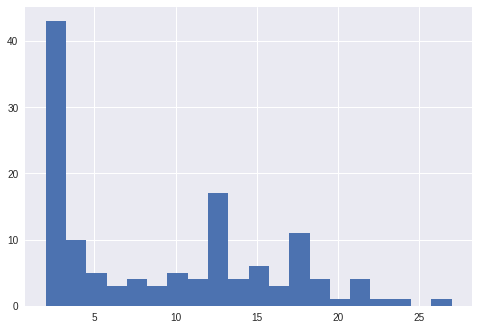

In [21]:
playlist_lengths = [len(playlist['filtered_lists'][0]) for playlist in playlists_subset]
plt.hist(playlist_lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(playlist_lengths))

`Song_id --> Song_name` mapping.

In [22]:
songID2Name = {s[1]: s[0] for p in playlists_subset for s in p['playlist']}

In [23]:
#songID2Name

## One-hot tag encoding

Indicator of tags: `tag` --> `index` mapping.

In [24]:
# the set of unique tags
tag_set = sorted(set(track2Tags.values()))

In [25]:
print('#Tags: %d' % len(tag_set))

#Tags: 15


In [26]:
tag_indicator = { tag: ix for ix, tag in enumerate(tag_set) }

In [27]:
tag_indicator

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}

## Feature extraction

Build features (1-hot encoding of tag) for a song given its `song_id`.

In [28]:
def gen_features(song_id, song2TrackID = song2TrackID, tag_indicator = tag_indicator):
    """
        Generate one-hot feature vector for a given song ID
    """

    features = np.zeros(len(tag_set), dtype = np.float)
    trackIDs = song2TrackID[song_id]

    cnt = 0
    for trackID in trackIDs:
        if trackID in track2Tags:
            cnt += 1
            tag = track2Tags[trackID]
            tag_ix = tag_indicator[tag]
            features[tag_ix] = 1

    # must have at least one tag for the song, else useless
    assert(cnt >= 1)

    return features

In [29]:
def gen_feature_map(song_id, seed):
    """
        Generate feature mapping for a given (label, query) pair
    """
    
    #return gen_features(song_id) - gen_features(seed)  # feature map
    return gen_features(seed)  # a trivial feature map

In [30]:
def gen_training_set(label_ix, playlists = playlists_subset, song_set = song_set):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - label_ix: song index, number in { 0, ..., # songs }
            - playlists: which playlists to create features for
            
        Output:
            - (Feature, Label) pair (X, y), with # num playlists rows
              X comprises the features for each seed song and the given song
              y comprises the indicator of whether the given song is present in the respective playlist
    """

    assert(label_ix >= 0)
    assert(label_ix < len(song_set))

    N = len(playlists)
    d = len(tag_set)

    X = np.zeros((N, d), dtype = np.float)
    y = np.zeros(N, dtype = np.float)
    
    whichSong = song_set[label_ix]
    
    for i in range(len(playlists)):
        playlist = playlists[i]['filtered_lists'][0]
        seed     = playlist[0]

        X[i,:] = gen_feature_map(whichSong, seed)
        y[i]   = int(whichSong in playlist)

    return X, y

In [31]:
gen_feature_map(song_set[100], playlists_subset[0]['filtered_lists'][0][0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.])

## Training & Testing

Train a logistic regression model for each label.

In [32]:
classifiers = [LogisticRegression(class_weight='balanced') for i in range(len(song_set))]

In [33]:
allPreds  = [ ]
allTruths = [ ]
coefMat = [ ]
labelIndices = [ ]

for label_ix in range(len(song_set)):
    X, y = gen_training_set(label_ix)
    
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, \
                                                                           test_size = 0.33, \
                                                                           random_state = 31)    
    
    if np.max(y_train) == 0.0: # or np.max(y_test) == 0.0:
        continue

    classifiers[label_ix].fit(X_train, y_train)
    
    allPreds.append(classifiers[label_ix].decision_function(X_test))
    allTruths.append(y_test)    

    coefMat.append(classifiers[label_ix].coef_.reshape(-1))
    labelIndices.append(label_ix)
    #print(classifiers[label_ix].coef_)
    #print(classifiers[label_ix].intercept_)

In [34]:
allPreds = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(43, 699)
(43, 699)


## Evaluation

Compute AUC.

Average AUC: 0.6577


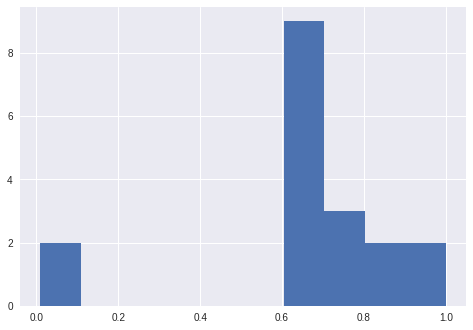

In [35]:
aucs = [ ]
for i in range(0,allPreds.shape[0]):
    pred  = allPreds[i,:]
    truth = allTruths[i,:]
    
    if np.max(truth) == 0.0:
        continue
    
    aucs.append(sk.metrics.roc_auc_score(truth, pred))
    
print('Average AUC: %1.4f' % np.mean(aucs))
plt.hist(aucs, bins = 10);

Compute average precision.

Coefficient matrix `(#Genres, #Songs)`.

In [36]:
coefMat = np.array(coefMat).T

In [37]:
coefMat.shape

(15, 699)

In [38]:
#sns.heatmap(coefMat[:, :30])

Top 10 songs of each genre (w.r.t.) the coefficients.

In [39]:
labelIndices = np.array(labelIndices)

In [40]:
Top10Songs_ix = [ ]
for i in range(coefMat.shape[0]):
    ix = np.argsort(coefMat[i, :])[::-1][:10]
    Top10Songs_ix.append(labelIndices[ix])

In [41]:
#Top10Songs_ix

In [42]:
#np.array(song_set)[Top10Songs_ix[0]]

In [43]:
Top10Songs = pd.DataFrame(np.zeros((len(tag_set), 10), dtype = object),
                          index = tag_set, columns = ['Top %d' % k for k in range(1, 11)])

In [44]:
for i in range(len(tag_set)):
    row = tag_set[i]
    for j in range(10):
        song_ix = Top10Songs_ix[i][j]
        songID = song_set[song_ix]
        songName = songID2Name[songID]
        col = 'Top %d' % (j+1)
        Top10Songs.loc[row, col] = songName

In [45]:
Top10Songs

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Blues,"[LCD Soundsystem, Watch The Tapes]","[morcheeba, blindfold]","[Radiohead, Permanent Daylight]","[Soundgarden, Black Hole Sun]","[evanescence, my immortal]","[Iron Butterfly, In-a-Gadda-Da-Vida (single ve...","[Alice in Chains, Them Bones]","[Radiohead, Anyone Can Play Guitar]","[The Damned, New Rose]","[Dar Williams, What Do You Hear In These Sounds]"
Country,"[Keith Urban, Who Wouldn't Wanna be Me]","[Nickel Creek, The Smoothie Song]","[Kenny Chesney, The Good Stuff]","[pedro the lion, of up and coming monarchs]","[Jim Noir, I Me You I'm Your]","[The Clash, Train in Vain]","[Gorillaz, Dare]","[The Stone Roses, Fools Gold]","[Garbage, Dog New Tricks]","[Radiohead, Vegetable (Live)]"
Electronic,"[Depeche Mode, Wrong]","[, Walking In My Shoes]","[dogs die in hot cars, godhopping]","[LCD Soundsystem, Someone Great]","[modest mouse, float on]","[morcheeba, part of the process]","[beth orton, central reservation(orbit mix)]","[morcheeba, let me see]","[happy mondays, 24 hour party people]","[LCD Soundsystem, All I Want]"
Folk,"[something corporate, space]","[michelle branch, where are you now]","[damien rice, volcano]","[linkin park, numb]","[trapt, headstrong]","[fuel, falls on me]","[3 doors down, going down in flames]","[chevelle, the red]","[matchbox twenty, busted (acoustic)]","[yellowcard, way away]"
Jazz,"[LCD Soundsystem, Watch The Tapes]","[morcheeba, blindfold]","[Radiohead, Permanent Daylight]","[Soundgarden, Black Hole Sun]","[evanescence, my immortal]","[Iron Butterfly, In-a-Gadda-Da-Vida (single ve...","[Alice in Chains, Them Bones]","[Radiohead, Anyone Can Play Guitar]","[The Damned, New Rose]","[Dar Williams, What Do You Hear In These Sounds]"
Latin,"[LCD Soundsystem, Watch The Tapes]","[morcheeba, blindfold]","[Radiohead, Permanent Daylight]","[Soundgarden, Black Hole Sun]","[evanescence, my immortal]","[Iron Butterfly, In-a-Gadda-Da-Vida (single ve...","[Alice in Chains, Them Bones]","[Radiohead, Anyone Can Play Guitar]","[The Damned, New Rose]","[Dar Williams, What Do You Hear In These Sounds]"
Metal,"[LCD Soundsystem, Watch The Tapes]","[morcheeba, blindfold]","[Radiohead, Permanent Daylight]","[Soundgarden, Black Hole Sun]","[evanescence, my immortal]","[Iron Butterfly, In-a-Gadda-Da-Vida (single ve...","[Alice in Chains, Them Bones]","[Radiohead, Anyone Can Play Guitar]","[The Damned, New Rose]","[Dar Williams, What Do You Hear In These Sounds]"
New Age,"[LCD Soundsystem, Watch The Tapes]","[morcheeba, blindfold]","[Radiohead, Permanent Daylight]","[Soundgarden, Black Hole Sun]","[evanescence, my immortal]","[Iron Butterfly, In-a-Gadda-Da-Vida (single ve...","[Alice in Chains, Them Bones]","[Radiohead, Anyone Can Play Guitar]","[The Damned, New Rose]","[Dar Williams, What Do You Hear In These Sounds]"
Pop,"[Christina Aguilera, Fighter]","[Britney Spears, Oops I Did It Again]","[Spice Girls, Wannabe]","[Michelle Branch, You Get Me]","[Christina Aguilera, Impossible]","[Christina Aguilera, Lady Marmalade]","[Lil Wayne, A Milli]","[Christina Aguilera, Beautiful]","[Nick Lachey, I Swear]","[Flo Rida, Low]"
Punk,"[the ataris, boys of summer]","[AFI, bleed black]","[AFI, death of seasons]","[Radiohead, Vegetable (Live)]","[The Clash, Train in Vain]","[Gorillaz, Dare]","[Belle & Sebastian, Step Into My Office, Baby]","[Garbage, Dog New Tricks]","[Jim Noir, I Me You I'm Your]","[pedro the lion, of up and coming monarchs]"
